In [1]:
import torch
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import time

plt.rcParams["font.family"] = "serif"

In [2]:
beta_crit = np.log(1 + np.sqrt(2)) / 2

In [3]:
class Sampler:
    def __init__(self, N, L, beta, dtype=torch.float16, device=torch.device('cpu')):
        self.dtype = dtype
        self.device = device
        self.beta = beta
        
        # Initial random states
        state_white, state_black = torch.randint(0, 2, (2, N, 1, L, L//2), dtype=dtype, device=device) * 2 - 1
        self.state_white = state_white
        self.state_black = state_black
        self.state = torch.zeros((N, 1, L, L), dtype=dtype, device=device)
        
        # Convolutional filter for 2D Ising with J=1.0
        self.kernel_white = torch.tensor([[0.0, 1.0, 0.0],
                                          [0.0, 1.0, 1.0],
                                          [0.0, 1.0, 0.0]], device=device, dtype=dtype).reshape(1, 1, 3, 3)
        self.kernel_black = torch.tensor([[0.0, 1.0, 0.0],
                                          [1.0, 1.0, 0.0],
                                          [0.0, 1.0, 0.0]], device=device, dtype=dtype).reshape(1, 1, 3, 3)
        
        # Masks to restore joined state
        mask_white = torch.zeros_like(self.state, dtype=torch.bool, device=device)
        mask_black = torch.zeros_like(self.state, dtype=torch.bool, device=device)
        mask_white[:, :,  ::2,  ::2] = 1
        mask_white[:, :, 1::2, 1::2] = 1
        self.mask_white = mask_white
        self.mask_black = ~mask_white

    def color_step(self, s1, s2, k1):
        s1 -= 2 * s1 * torch.bernoulli(
            torch.exp(
                -torch.clamp_min(
                    s1 * F.conv2d(s2, k1, padding=1), 0
                ) * (self.beta * 2)
            )
        )
        
    def step(self):
        self.color_step(self.state_white, self.state_black, self.kernel_white)
        self.color_step(self.state_black, self.state_white, self.kernel_black)
    
    def energy(self):
        neighbor_sum_white = F.conv2d(self.state_black, self.kernel_white, padding=1)
        neighbor_sum_black = F.conv2d(self.state_white, self.kernel_black, padding=1)
        total_energy  = - torch.sum((self.state_white * neighbor_sum_white).float(), axis=(1,2,3)) / 2
        total_energy += - torch.sum((self.state_black * neighbor_sum_black).float(), axis=(1,2,3)) / 2
        return total_energy

    @property
    def joined_state(self):
        self.state[self.mask_white] = self.state_white.view(-1)
        self.state[self.mask_black] = self.state_black.view(-1)
        return self.state

In [4]:
device = torch.device('cuda')
dtype = torch.float16

## Example

In [5]:
L = 1_000
N = 3
beta = torch.tensor([beta_crit * 0.95, 0.97 * beta_crit, beta_crit * 0.99], dtype=dtype, device=device).view(-1, 1, 1, 1)

sampler = Sampler(N, L, beta, dtype=dtype, device=device)

In [6]:
for _ in tqdm(range(10_000)):
    sampler.step()
torch.cuda.synchronize()

100%|██████████| 10000/10000 [00:02<00:00, 4210.78it/s]


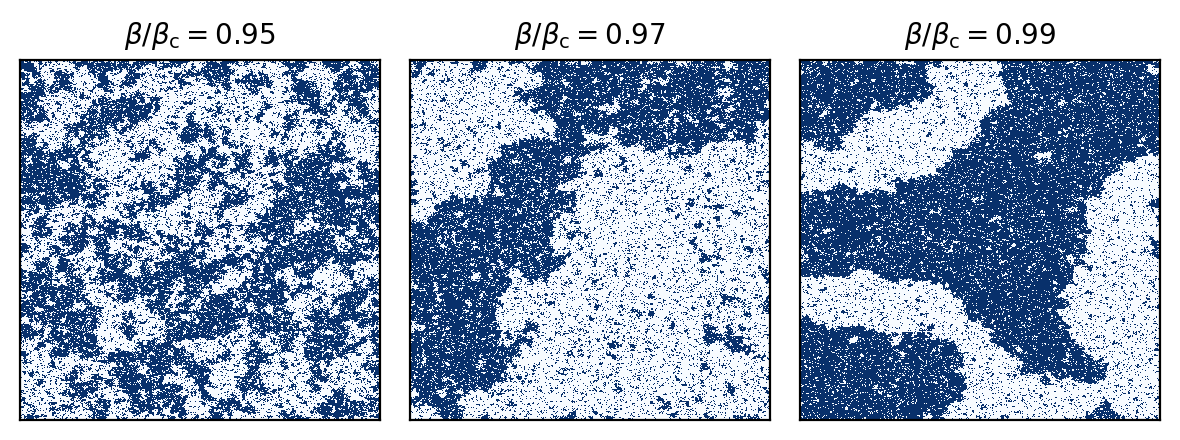

In [7]:
state = sampler.joined_state

titles = [r'$\beta/\beta_\mathrm{c} = 0.95$', r'$\beta/\beta_\mathrm{c} = 0.97$', r'$\beta/\beta_\mathrm{c} = 0.99$']
fig, axs = plt.subplots(1, 3, figsize=(6,3), dpi=200)
for (j, ax) in enumerate(axs):
    ax.matshow(state[j, 0].cpu().numpy(), cmap='Blues')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[j], size=10)
plt.tight_layout()
plt.show()